In [1]:
import mdtraj as md
import os, sys, importlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

def source_module_attr(module_file:str, attr_name:str, local_attr_name:str = None):
    
    """to add a module from a user defined python script into the local name space"""
    
    #
    if local_attr_name is None:
        local_attr_name = attr_name
    
    if len(module_file.split("/")) == 1 or module_file.split("/")[-2] == ".":
        module_dir = os.getcwd()
    else:
        module_dir = "/".join(module_file.split("/")[:-1])

    sys.path.insert(0, module_dir)
    
    module = importlib.import_module(module_file.split("/")[-1][:-3])
    
    g = globals()
    g[local_attr_name] = getattr(module, attr_name)
    
    pass

#source writhe and visualization scripts being developed
source_module_attr("./writhe_graph.py", "WritheGraph")
source_module_attr("./writhe.py", "Writhe")
source_module_attr("./lightning_graph.py", "GraphDataSet")
source_module_attr("./visualize.py", "make_structures")
source_module_attr("./visualize.py", "plot_structure")


 # Load MDTraj Trajectory Object

In [115]:
dcd = "./asyn/asyn_Cterm_apo.all.dcd"
pdb = "./asyn/asyn.cterm.mae2pdb.pdb"

# dcd = "./asyn/asyn_full_lig47_trunc.protein.dcd"
# pdb = "./asyn/asyn_full_lig47_trunc.protein.pdb"


# dcd = "/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd"
# pdb = "/home/t/writhe/actr/ACTR.pdb"

# table,bonds = md.load(pdb).topology.to_dataframe()
# table.sort_values("resSeq", inplace = True, ignore_index = True)
# top = md.Topology.from_dataframe(table, bonds)
trj = md.load(dcd, top=pdb).center_coordinates()
trj = trj.atom_slice(trj.topology.select("protein and not resid 20"))
residues=[str(trj.topology.residue(i)) for i in range(trj.n_residues)]

 # Compute Writhe, Generate Matrices For Visualization and Store Results In Writhe Class Instance For Plotting Later

In [121]:
#get CA coords
xyz = trj.atom_slice(trj.topology.select("name CA")).xyz
#instantiate writhe class
writhe = Writhe(xyz)
#compute writhe at segment length : 3 (uses parallelization over the cpu cores)
writhe_data = writhe.compute_writhe(length = 3,
                                    matrix = True,
                                    store_results = True,
                                    return_segments=False,
                                    adj_matrix=False)

 # Test Speed The Parallelized Computation

In [122]:
#test the speed of the calculation without storing and reshaping data
writhe.compute_writhe(length=2, speed_test=True)
print(f"Frame Count : {trj.n_frames}")

Time elapsed : 11.194522380828857 s
Frame Count : 555445


# Use Writhe Class Plotting Functions to visualize the results.
# The make_structures and plot_structure functions generate pymol respresentations of the structures corresponding to the writhe data on the fly.

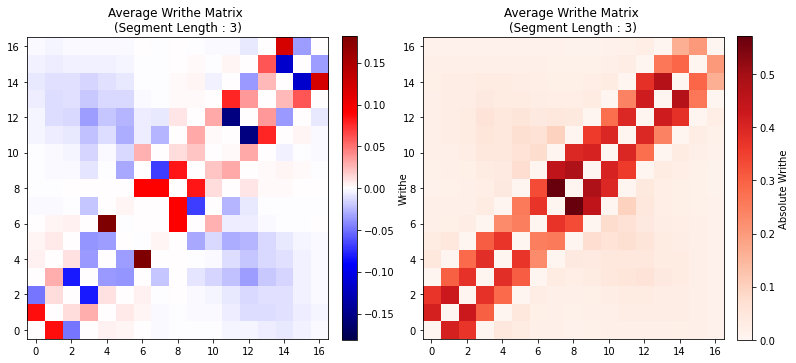

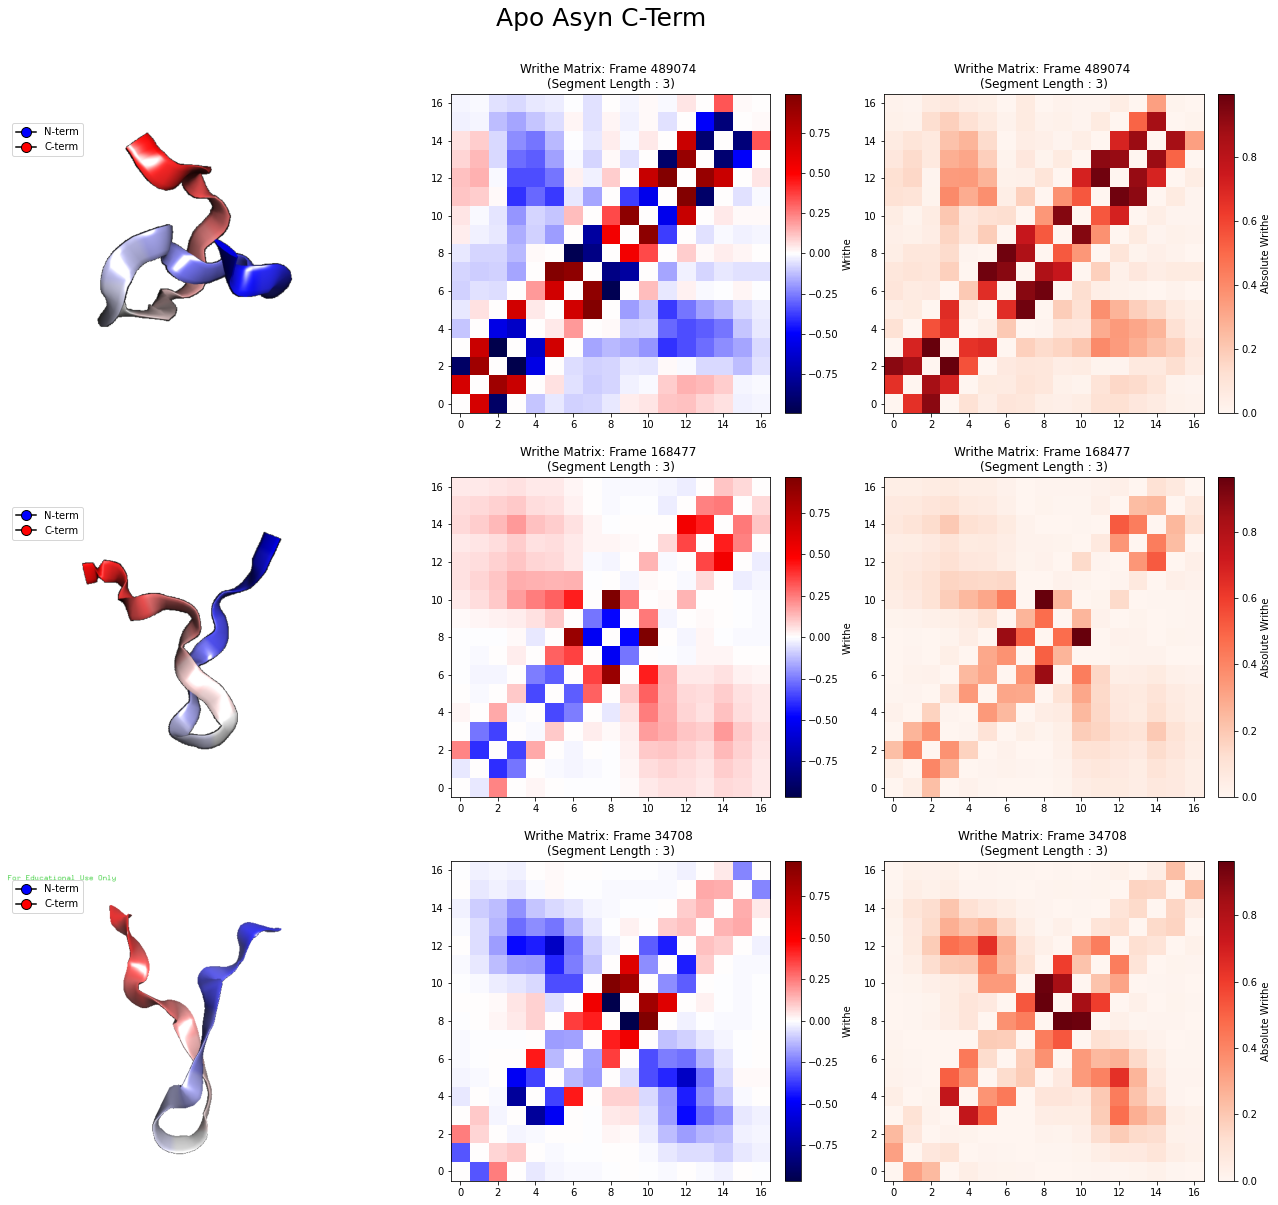

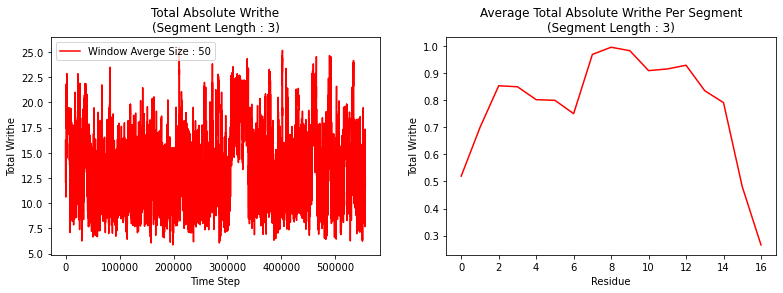

In [123]:
fig, axes = plt.subplots(1,2,figsize=(13,13))
ax=axes.flat
#plot the average 
writhe.plot_writhe_matrix(ax=ax[0])
#plot the absolute value average
writhe.plot_writhe_matrix(absolute=True,ax=ax[1])

#plot the writhe matrix at different timesteps
fig,axes=plt.subplots(3,3, figsize=(22,20))

#asyn apo c-term indices : idx[0], 168477, 34708

idx=abs(writhe_data["writhe_features"]).sum(1).argsort()[::-1].astype(int)

fig.suptitle('Apo Asyn C-Term', fontsize=25, y=.94)
for ax, index in zip(axes, [idx[0], 168477, 34708]):
    structure=make_structures(trj=trj, indices=index, dir="./asyn/apo/images")
    plot_structure(image=structure, ax=ax[0])
    writhe.plot_writhe_matrix(index=index, ax=ax[1])
    writhe.plot_writhe_matrix(index=index, ax=ax[2], absolute=True)
    
    
#plot the total absolute writhe in a time series with a windowed average
fig, axes = plt.subplots(1,2,figsize=(13,4))
ax=axes.flat
writhe.plot_writhe_total(window=50,ax=ax[0])
#plot the average absolute writhe per segment
writhe.plot_writhe_per_segment(ax=ax[1])


# Use Same Instance To Compute and Plot Writhe Data At Different Segment Lengths

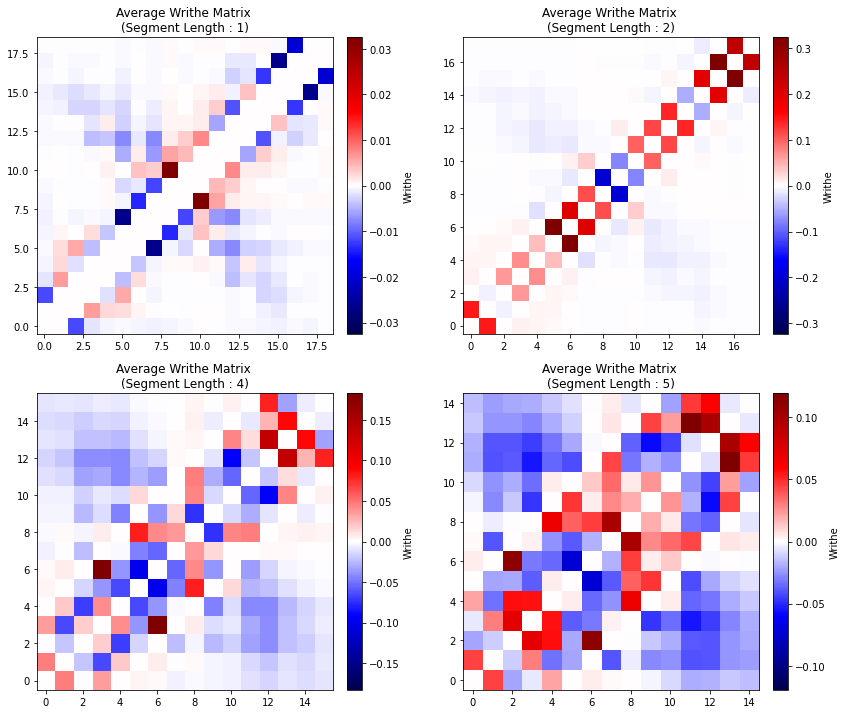

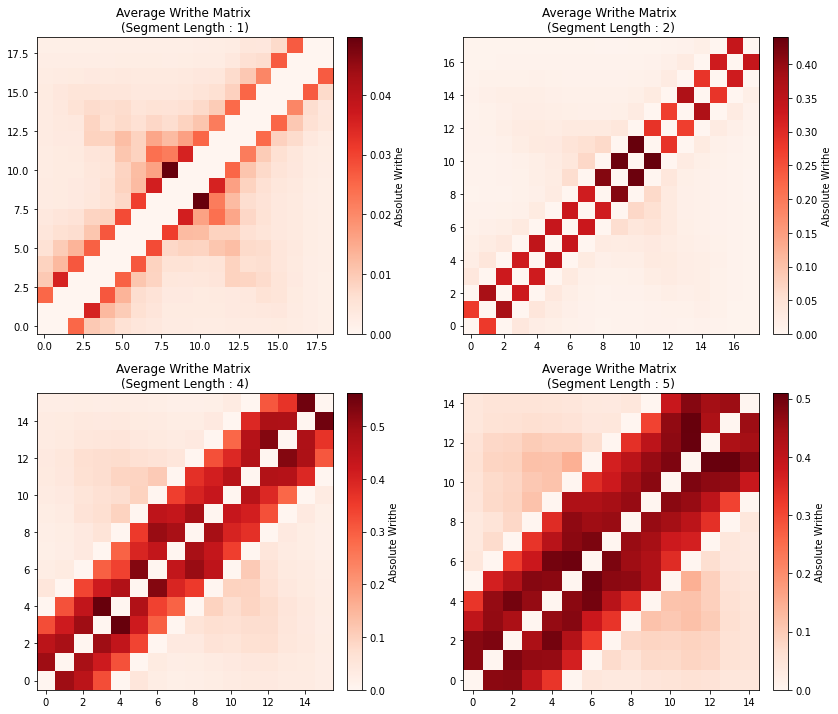

In [119]:
#compute and plot the writhe for different segment lengths
fig, axes = plt.subplots(2,2, figsize=(14,12))
fig_abs, axes_abs = plt.subplots(2,2, figsize=(14,12))
for ax, ax_abs,length in zip(axes.flat, axes_abs.flat, [1,2,4,5]):
    writhe_data_ = writhe.compute_writhe(length = length,
                                         matrix = True,
                                         store_results = True,
                                        )
    writhe.plot_writhe_matrix(ax=ax)
    writhe.plot_writhe_matrix(ax=ax_abs,absolute=True)

 # Let's try a geometrically perfect helix

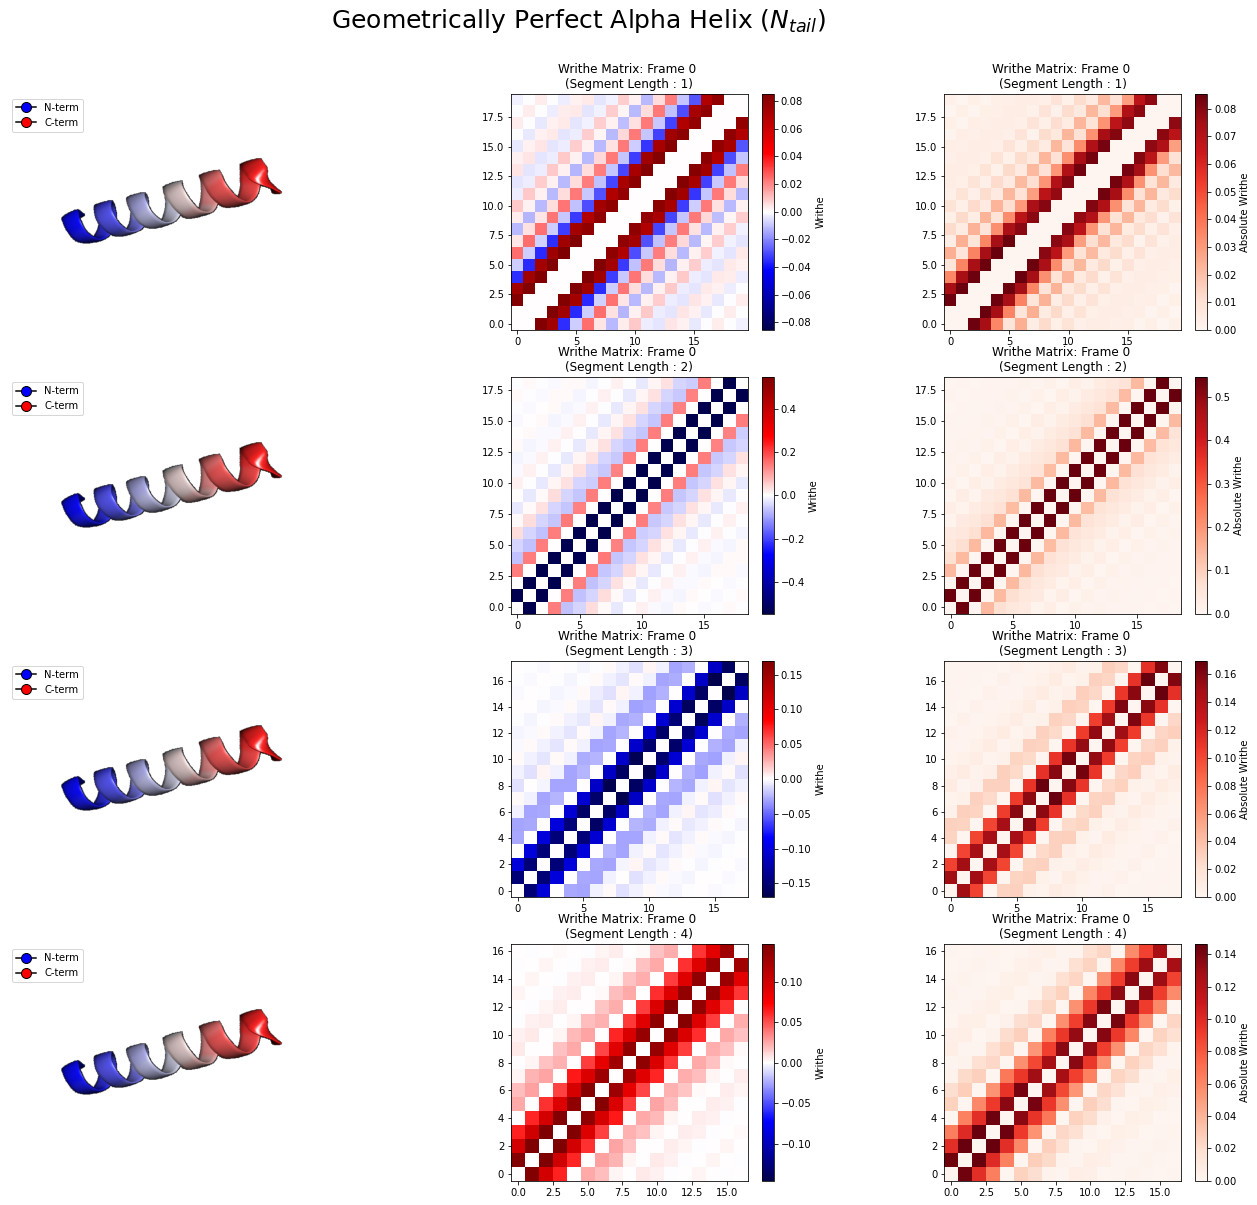

In [114]:
helix = md.load("./Ntail.helix.pdb")
#get CA coords
xyz_helix = helix.atom_slice(helix.topology.select("name CA")).xyz
#instantiate writhe class
writhe_helix = Writhe(xyz_helix)
#compute writhe at segment length : 4 (uses parallelization over the cpu cores)

fig,axes=plt.subplots(4,3, figsize=(22,20))
structure=make_structures(trj=helix, indices=0, dir="./ntail_helix/images")

fig.suptitle('Geometrically Perfect Alpha Helix ($N_{tail}$)', fontsize=25, y=.94)
for ax, segment_length in zip(axes, [1,2,3,4]):
    writhe_data = writhe_helix.compute_writhe(length = segment_length,
                                matrix = True,
                                store_results = True,
                                return_segments=False,
                                adj_matrix=False)
    plot_structure(image=structure, ax=ax[0])
    writhe_helix.plot_writhe_matrix(index=0, ax=ax[1])
    writhe_helix.plot_writhe_matrix(index=0, ax=ax[2], absolute=True)

 # Make Graph Representations For All Frames of The Trajectory

In [7]:
#make instance of writhe graph
graph = WritheGraph(trj)

#add edge features
graph.add_dihedrals() #0,1
graph.add_angles() #2,3
graph.add_intra_distances() #4
graph.add_writhe(segment_length = 1) #5
graph.add_writhe(segment_length = 3) #6
graph.add_writhe(segment_length = 5) #7

#add node_features
#graph.add_ligand_distances() #0
graph.add_dssp() #1
graph.add_rsa() #2

#set up
graph.make_edge_dict()

In [8]:
#make a graph for each frame
graphs = [graph.get_graph(i) for i in range(graph.nf)]

#set a directory to save to
root="./actr/graphs"
os.mkdir(root)

# GraphDataSet class collates all graph examples into one giant graph
# and stores them for efficient access during training

graph_dataset = GraphDataSet(root=root, name="graph", data_list=graphs)

Processing...
Done!
